<a href="https://colab.research.google.com/github/arumm25/Repo1-PenambanganData/blob/main/Eksperimen%20Akhir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from google.colab import drive

# =========================
# 2. Path dataset di Drive
# =========================
DATASET_PATH = '/content/drive/MyDrive/Penambangan Data/Water Bodies Dataset'

# =========================
# 3. Cek dataset
# =========================
if not os.path.exists(DATASET_PATH):
    print(f"❌ Dataset tidak ditemukan di {DATASET_PATH}")
else:
    print("✅ Dataset ditemukan!")
    print("\n📂 Struktur dataset:")

    for root, dirs, files in os.walk(DATASET_PATH):
        level = root.replace(DATASET_PATH, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")

        subindent = ' ' * 4 * (level + 1)
        for f in files[:3]:
            print(f"{subindent}{f}")
        if len(files) > 3:
            print(f"{subindent}... ({len(files)-3} file lainnya)")

✅ Dataset ditemukan!

📂 Struktur dataset:
Water Bodies Dataset/
    Images/
        water_body_7776.jpg
        water_body_782.jpg
        water_body_7819.jpg
        ... (2838 file lainnya)
    Masks/
        water_body_7969.jpg
        water_body_7827.jpg
        water_body_7834.jpg
        ... (2838 file lainnya)


In [ ]:
!pip install opencv-python
!pip install tensorflow

In [ ]:
# 1. SETUP & IMPORT
import os
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Konfigurasi
IMG_W = 256 # Resize ke 256x256 (Standar U-Net agar pembagian pixel mulus)
IMG_H = 256
IMG_CH = 3  # RGB
BATCH_SIZE = 8
LR = 1e-4   # Learning Rate
EPOCHS = 10 # Bisa ditambah kalau kurang akurat

# Path (Sesuaikan jika path di drive berbeda)
DATA_PATH = "/content/drive/MyDrive/Penambangan Data/Water Bodies Dataset"

In [ ]:
# 2. DATA PREPROCESSING FUNCTION
def load_data(path):
    # Ambil semua file path dan SORT agar urutan Image dan Mask sama
    images = sorted(glob(os.path.join(path, "Images/*")))
    masks = sorted(glob(os.path.join(path, "Masks/*")))

    return images, masks

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMG_W, IMG_H))
    x = x / 255.0 # Normalisasi jadi 0-1
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # Mask hanya butuh 1 channel
    x = cv2.resize(x, (IMG_W, IMG_H))
    x = x / 255.0 # Normalisasi jadi 0-1
    x = x > 0.5   # Binarization (Pastikan nilainya tegas 0 atau 1)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1) # Tambah dimensi jadi (256, 256, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([IMG_H, IMG_W, IMG_CH])
    y.set_shape([IMG_H, IMG_W, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
# 3. U-NET ARCHITECTURE (STANDARD)
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder (Turun)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge (Jembatan Bawah)
    b1 = conv_block(p4, 1024)

    # Decoder (Naik)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output Layer (Binary Segmentation: Water or Not Water)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
# 4. MAIN EXECUTION
# Load Paths
images, masks = load_data(DATA_PATH)
print(f"Dataset Loaded: {len(images)} Images, {len(masks)} Masks")

# Split Data (80% Train, 20% Val)
train_x, valid_x, train_y, valid_y = train_test_split(images, masks, test_size=0.2, random_state=42)

# Create TF Dataset pipeline
train_dataset = tf_dataset(train_x, train_y, batch=BATCH_SIZE)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH_SIZE)

# Build Model
model = build_unet((IMG_H, IMG_W, IMG_CH))
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# Train
print("Mulai Training...")
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Dataset Loaded: 2841 Images, 2841 Masks


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

Mulai Training...
Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 4892s 17s/step - accuracy: 0.7748 - loss: 0.4929 - val_accuracy: 0.5411 - val_loss: 0.7758
Epoch 2/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 137s 483ms/step - accuracy: 0.8396 - loss: 0.3906 - val_accuracy: 0.8385 - val_loss: 0.4007
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 146s 513ms/step - accuracy: 0.8561 - loss: 0.3548 - val_accuracy: 0.8617 - val_loss: 0.3407
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 147s 517ms/step - accuracy: 0.8658 - loss: 0.3337 - val_accuracy: 0.8681 - val_loss: 0.3242
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 198s 503ms/step - accuracy: 0.8761 - loss: 0.3147 - val_accuracy: 0.8650 - val_loss: 0.3276
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 146s 515ms/step - accuracy: 0.8817 - loss: 0.3029 - val_accuracy: 0.8570 - val_loss: 0.3379
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 148s 520ms/step - accuracy: 0.8868 - loss: 0.2892 - val_accuracy: 0.8651 - val_loss: 0.3192
Epoch 8/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 148s 521ms/step - a

In [ ]:
# 5. SAVE MODEL UNTUK NEXT.JS/PYTHON BACKEND
model.save("water_unet_model.h5")
print("Model berhasil disimpan sebagai water_unet_model.h5")

Model berhasil disimpan sebagai water_unet_model.h5


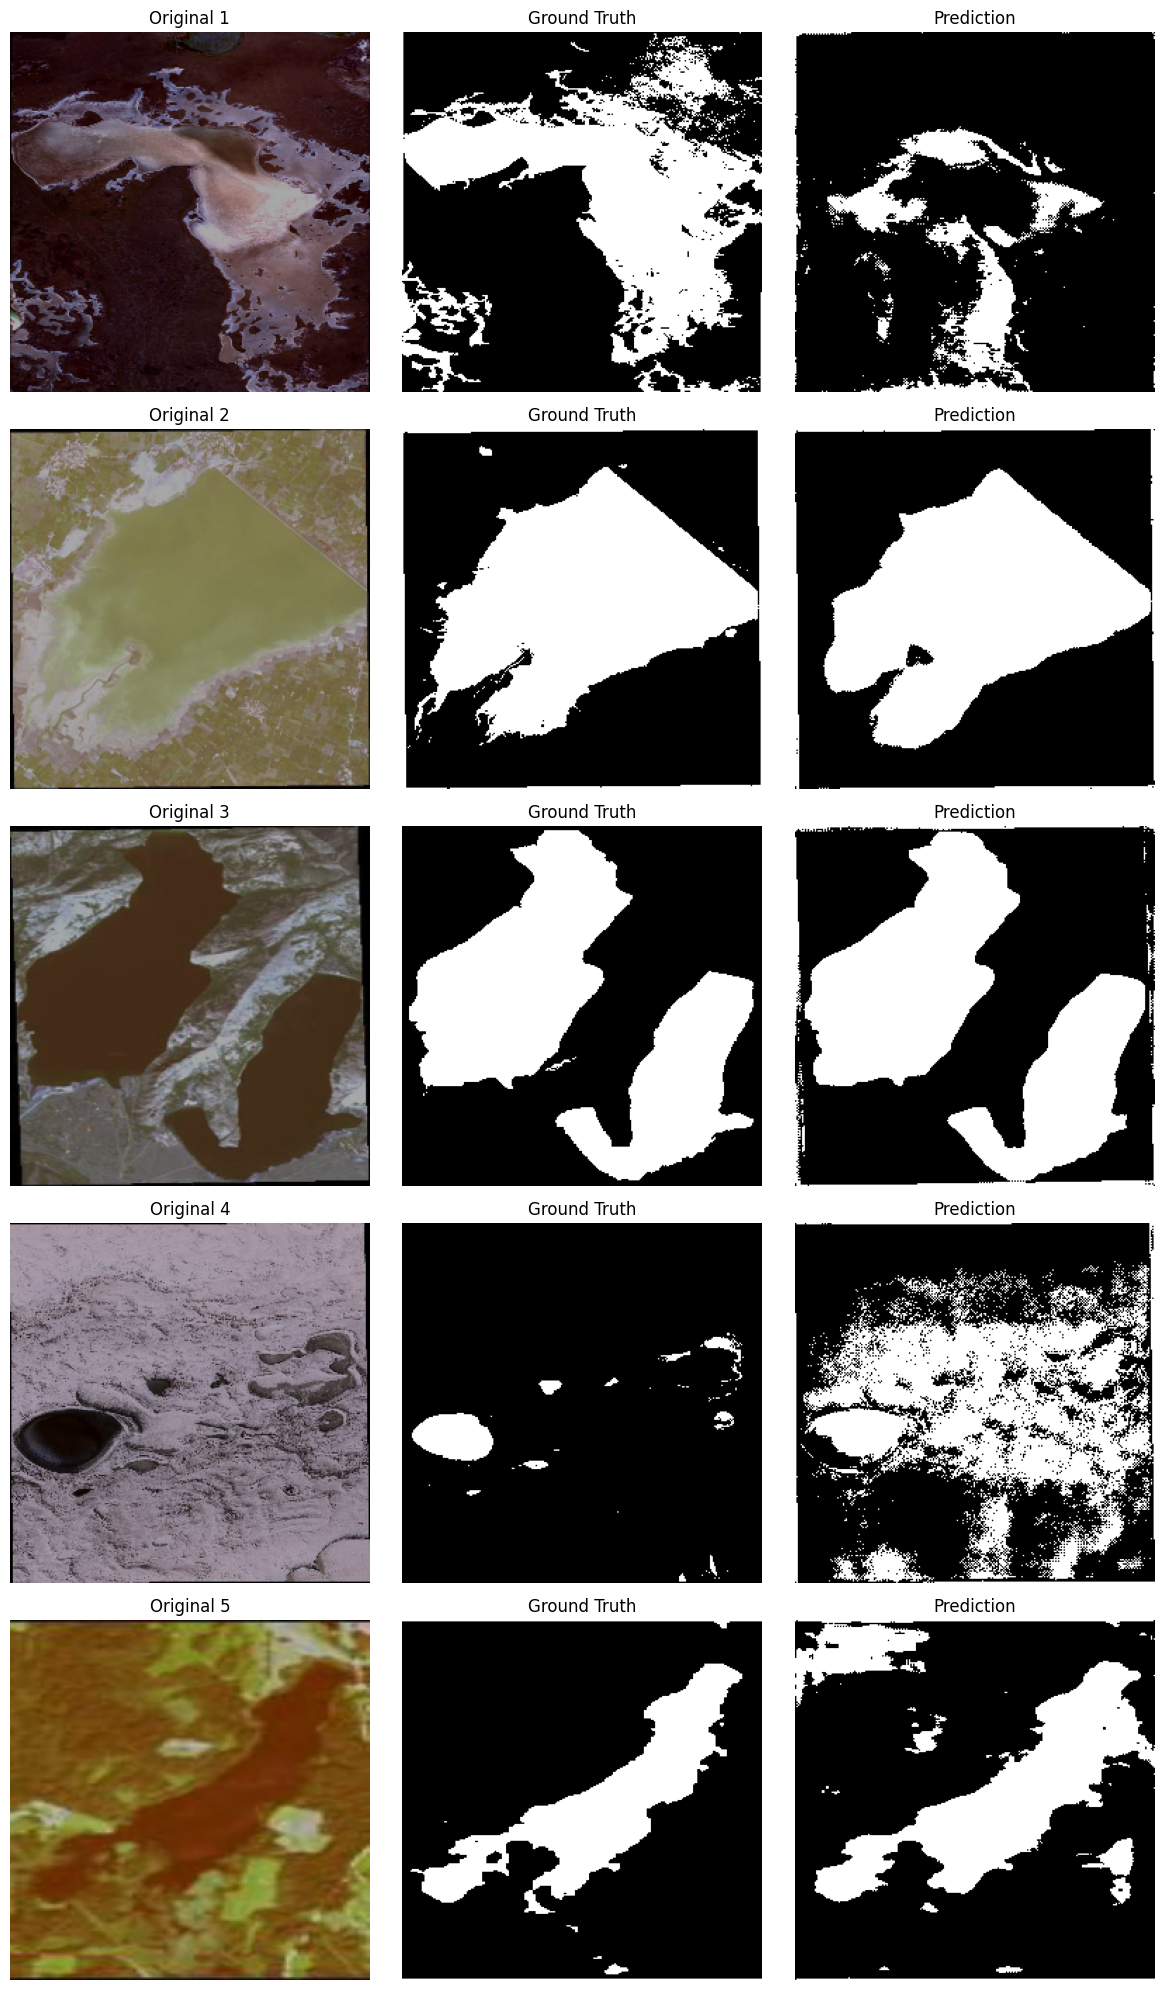

In [ ]:
# 6. TEST VISUALIZATION (Cek hasil sepintas)

# Redefine read_image and read_mask to handle string paths directly
def read_image(path):
    # Removed path.decode() as path will be a string when called directly here
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    if x is None:
        raise FileNotFoundError(f"Image not found at {path}")
    x = cv2.resize(x, (IMG_W, IMG_H))
    x = x / 255.0 # Normalize to 0-1
    x = x.astype(np.float32)
    return x

def read_mask(path):
    # Removed path.decode() as path will be a string when called directly here
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # Mask needs 1 channel
    if x is None:
        raise FileNotFoundError(f"Mask not found at {path}")
    x = cv2.resize(x, (IMG_W, IMG_H))
    x = x / 255.0 # Normalize to 0-1
    x = x > 0.5   # Binarization (ensure values are strictly 0 or 1)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1) # Add dimension to (256, 256, 1)
    return x

def visualize_predictions(model, image_paths, mask_paths, n=5):
    plt.figure(figsize=(12, 4 * n))

    for i in range(n):
        # Read Image
        x = read_image(image_paths[i])

        # Predict
        y_pred = model.predict(np.expand_dims(x, axis=0), verbose=0)[0]
        y_pred = y_pred > 0.5

        # Read GT Mask
        y_true = read_mask(mask_paths[i])

        # Plot
        plt.subplot(n, 3, i*3 + 1)
        plt.title(f"Original {i+1}")
        plt.imshow(x)
        plt.axis("off")

        plt.subplot(n, 3, i*3 + 2)
        plt.title("Ground Truth")
        plt.imshow(y_true.squeeze(), cmap='gray')
        plt.axis("off")

        plt.subplot(n, 3, i*3 + 3)
        plt.title("Prediction")
        plt.imshow(y_pred.squeeze(), cmap='gray')
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Tampilkan 5 data validasi
visualize_predictions(model, valid_x, valid_y, n=5)
